In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback

In [2]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe
df = pd.read_csv("mlware23/dataset/train/train_faces.csv", dtype = dt)

In [3]:
df.head(5)

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,hwJUKjziH0.jpg,22,20,14,04,43,40,35,53,25,...,31,41,13,32,33,10,02,30,50,44
1,smzyIVQ4Ve.jpg,03,50,43,14,05,13,33,52,01,...,41,35,45,30,44,22,51,00,32,15
2,IT3H2QbaJY.jpg,55,25,43,10,33,20,22,13,54,...,00,42,11,41,12,23,30,51,35,32
3,Yceag6Ca0B.jpg,12,32,52,05,15,42,55,04,10,...,34,20,13,21,22,45,33,41,23,35
4,nDBcp5ZyPj.jpg,33,44,12,45,50,54,20,24,00,...,55,34,04,25,52,15,11,21,02,32


In [4]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("mlware23/dataset/train/faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'ground_truth')

<Figure size 432x288 with 0 Axes>

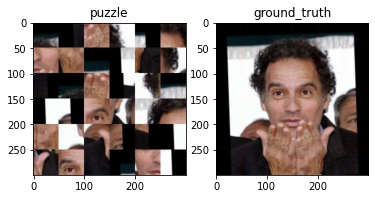

In [5]:
puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

In [6]:
#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

In [7]:
# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a seperate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("mlware23/dataset/train/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [8]:
train_img = load_images(train_df)
val_img = load_images(val_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.21it/s]


In [9]:
print(train_img.shape)
print(val_img.shape)
#2400 puzzles, 36 pieces, each piece is a 50x50x3 image

(80, 36, 50, 50, 3)
(19, 36, 50, 50, 3)


In [10]:
'''
a function that one hot encodes the given labels.
we have a total of 36 puzzle pieces and 36 possible positions for each of those pieces
if piece at index i has its correct position at index j, we make label[i][j] = 1 
and all the other values in label[i] are set to 0

we iterate through all positions using i and j.
for each position, its index out of 36 will be i*6+j 
and same for the value in that column
'''
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

In [11]:
train_labels = load_labels(train_df)
val_labels = load_labels(val_df)

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2228.58it/s]


In [12]:
print(train_labels.shape)
print(val_labels.shape)
#2400 puzzles, 36x36 one hot encoded matrix as output

(80, 36, 36)
(19, 36, 36)


# Model Architecture

In [13]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch1 = tf.keras.layers.BatchNormalization()
max_pool1 = tf.keras.layers.MaxPooling2D()
conv2 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch2 = tf.keras.layers.BatchNormalization()
max_pool2 = tf.keras.layers.MaxPooling2D()
conv3 = tf.keras.layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', strides=2)
batch3 = tf.keras.layers.BatchNormalization()
d3 = tf.keras.layers.Dropout(0.4)
flat = tf.keras.layers.Flatten()
flat = tf.keras.layers.Flatten()
dense1 = tf.keras.layers.Dense(36)

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i])
    x = batch1(x)
    x = max_pool1(x)
    x = conv2(x)
    x = batch2(x)
    x = max_pool2(x)
    x = conv3(x)
    x = batch3(x)
    x = d3(x)
    x = flat(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [14]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [16]:
filepath = f'checkpoint/'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_weights_only=False, save_best_only=True)
tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [tensorboard, checkpoint]

In [17]:
# tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand

In [18]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=10,
          callbacks = [callbacks_list])

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 4.9079
Epoch 1: val_loss improved from inf to 6.77747, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
5/5 [==============================] - 33s 6s/step - loss: 4.9079 - val_loss: 6.7775
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 3.9500
Epoch 2: val_loss improved from 6.77747 to 3.79637, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
5/5 [==============================] - 28s 6s/step - loss: 3.9500 - val_loss: 3.7964
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 3.6331
Epoch 3: val_loss improved from 3.79637 to 3.06778, saving model to checkpoint\
INFO:tensorflow:Assets written to: checkpoint\assets
5/5 [==============================] - 30s 6s/step - loss: 3.6331 - val_loss: 3.0678
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 3.3930
Epoch 4: val_loss improved from 3.06778 to 2.91550, saving

In [19]:
def load_test_image_data(test_data_path):
    
    x_test = []
    
    dir_lst = os.listdir(test_data_path)
    
    for i in dir_lst:
        pieces = []
        img = Image.open(test_data_path+'/'+i)
        img = np.array(img)
#         print(im.size)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        x_test.append(pieces)
    return np.array(x_test)


test_data_path = 'mlware23/dataset/test/faces'
print('Number of Images in the face test dataset:',len(os.listdir(test_data_path)))
x_test = load_test_image_data(test_data_path)
print(x_test.shape)

Number of Images in the face test dataset: 900
(900, 36, 50, 50, 3)


In [20]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=-1)

In [21]:
print(pred.shape)
print(pred)
# 600 puzzles, 36 predicted permutations

(900, 36)
[[13 21  9 ... 18 17 10]
 [21  3  8 ...  5 34  7]
 [ 9 10 27 ... 13  6  7]
 ...
 [20 27  9 ... 34 30 14]
 [20 28 21 ... 20 16 26]
 [35 27 34 ... 35  8 35]]


In [22]:
print(pred[0])
#predicted permutation for 0th puzzle

[13 21  9 33  2 15 20  8 11 25 25 30 17 33 32 26 32 20 17 17  0 10 12  1
  1 16 27 17 13 17  2 10 14 18 17 10]


In [23]:
#formatting our predictions into pandas dataframe
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

# image_df = pd.DataFrame(val_df["image"])
# label_df = pd.DataFrame(pred_list)
test_data_path = 'mlware23/dataset/test/faces'
test_data_dir = os.listdir(test_data_path)
image_df = pd.DataFrame(i for i in test_data_dir)
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [24]:
out

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,00iOHCZTws.jpg,21,33,13,53,02,23,32,12,15,...,43,25,21,25,02,14,22,30,25,14
1,03fxX7jYxI.jpg,33,03,12,15,31,52,25,20,02,...,15,24,31,42,30,43,02,05,54,11
2,05evYM76RD.jpg,13,14,43,33,34,15,13,25,41,...,45,32,15,30,23,03,30,21,10,11
3,08UaxmNJtO.jpg,34,24,22,55,55,55,42,34,43,...,33,42,04,12,55,51,42,24,02,50
4,09gb5hcslV.jpg,40,13,30,55,53,25,50,13,43,...,30,15,24,02,01,02,55,32,42,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zN7NiY1cqe.jpg,10,05,32,10,52,10,43,42,30,...,32,32,34,15,34,34,32,24,34,33
896,zp165RuFlf.jpg,20,22,11,53,14,14,40,41,54,...,13,12,43,32,14,31,31,30,23,21
897,ZsbsreTu7O.jpg,32,43,13,13,43,12,05,50,32,...,32,13,14,32,02,24,33,54,50,22
898,ZVmd0y6z7W.jpg,32,44,33,14,23,31,21,32,42,...,34,13,55,21,41,12,51,32,24,42


In [25]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [26]:
submission = prediction_to_submission(out)

In [27]:
submission
# we do this inference for testing data of landscape as well as faces dataset and then concatenate the dataframes

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,00iOHCZTws.jpg,2,3,1,5,0,2,3,1,1,...,3,5,1,5,2,4,2,0,5,4
1,03fxX7jYxI.jpg,3,0,1,1,3,5,2,2,0,...,5,4,1,2,0,3,2,5,4,1
2,05evYM76RD.jpg,1,1,4,3,3,1,1,2,4,...,5,2,5,0,3,3,0,1,0,1
3,08UaxmNJtO.jpg,3,2,2,5,5,5,4,3,4,...,3,2,4,2,5,1,2,4,2,0
4,09gb5hcslV.jpg,4,1,3,5,5,2,5,1,4,...,0,5,4,2,1,2,5,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zN7NiY1cqe.jpg,1,0,3,1,5,1,4,4,3,...,2,2,4,5,4,4,2,4,4,3
896,zp165RuFlf.jpg,2,2,1,5,1,1,4,4,5,...,3,2,3,2,4,1,1,0,3,1
897,ZsbsreTu7O.jpg,3,4,1,1,4,1,0,5,3,...,2,3,4,2,2,4,3,4,0,2
898,ZVmd0y6z7W.jpg,3,4,3,1,2,3,2,3,4,...,4,3,5,1,1,2,1,2,4,2


In [29]:
submission.to_csv('MY_FACE_PREDS.csv', index=False)